In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#Crop vùng template theo tọa độ trên ảnh gốc
def extract_image(image, points):
    (x1, y1), (x2, y2) = points # Lấy tọa độ hai góc đối diện

    roi = image[y1:y2, x1:x2] # Cắt ảnh theo tỉ lệ rộng - dài

    return roi

In [3]:
'''
Tính toán IoU (Intersection over Union) giữa 2 vị trí u và v
u = (x1, y1), v = (x2, y2) là hai điểm trung tâm của hai vùng cần so sánh
Dựa trên shape của template đã crop
'''

def iou(u, v, shape):
    height, width = shape
    x1, y1 = u
    x2, y2 = v

    # Xác định biên của vùng giao nhau
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + width, x2 + width)
    y_bottom = min(y1 + height, y2 + height)

    # Nếu không có giao nhau
    if x_right <= x_left or y_bottom <= y_top:
        return 0

    # Diện tích phần giao nhau
    intersection = (x_right - x_left) * (y_bottom - y_top)

    # Diện tích hai hình chữ nhật
    area_u = width * height
    area_v = width * height

    # IoU = Intersection / Union
    return intersection / (area_u + area_v - intersection)

In [4]:
class TemplateMatching():
    def __init__(self, points, path):
        self.points = points # Lưu tọa độ template
        self.path = path # Ảnh gốc

        self.image_viz = cv2.imread(path)
        self.obj_viz = extract_image(self.image_viz, points) # Crop template

        self.image = cv2.imread(path)[:,:,2] # Lấy kênh Green
        cv2.imwrite('object.png', self.obj_viz) # Lưu template
        self.obj = cv2.imread('object.png')[:,:,2] # Lấy kênh Green
        self.locs = [] # Lưu các template

    def visualize(self):
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(self.image_viz, cv2.COLOR_BGR2RGB))

    def template_matching_algo(self, threshold=0.027, method=cv2.TM_SQDIFF_NORMED):
        img2 = self.image.copy() # Tạo bản sao cho ảnh gốc để tìm template
        tem = self.obj.copy() # Sao chép template để so sánh

        # template matching
        result = cv2.matchTemplate(img2, tem, method) # Tìm template trong ảnh
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result) # Lấy giá trị min, max của kết quả
        for i in range(result.shape[0]): # Duyệt qua từng pixel trong ảnh kết quả
            for j in range(result.shape[1]):
                if result[i, j] < threshold: # Kiểm tra nếu giá trị tương tự nhỏ hơn threshold
                    self.locs.append((j, i)) # Lưu lại vị trí của kết quả khớp
        count = 1
        for loc in self.locs:  # Duyệt qua các vị trí khớp
            bottom_right = (loc[0] + tem.shape[1], loc[1] + tem.shape[0]) # Tính vị trí góc dưới bên phải của hình chữ nhật
            cv2.rectangle(self.image_viz, loc, bottom_right, (0, 0, 0), 2) # Vẽ bounding box bao quanh vị trí khớp
            cv2.putText(self.image_viz, str(count), (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
            count += 1

    # Filter out duplicate matched regions by measuring IoU (Intersection over Union)
    def filter(self):
        final_des = [] # Danh sách các kết quả khớp đã được lọc
        tem = self.obj  # Template để so sánh

        print(f"Original locs (before filtering): {len(self.locs)} matches found.")

        # Filter locations based on IoU
        for u in self.locs:  # Duyệt qua các output khớp
            if len(final_des) == 0:
                final_des.append(u)
            else:
                check = True
                for v in final_des: # Kiểm tra kết quả khớp với các kết quả trong final_des
                    overlap = iou(u, v, tem.shape) 
                    if overlap > 0.5: # Nếu IoU lớn hơn 0.5, loại bỏ kết quả này
                        check = False
                if check:
                    final_des.append(u)

        print(f"Filtered locs (after IoU filtering): {len(final_des)} unique matches found.")

        count = 1
        img3 = cv2.imread(self.path) # Đọc lại ảnh gốc để hiển thị kết quả sau khi lọc
        for loc in final_des:  # Duyệt qua các kết quả sau khi lọc
            bottom_right = (loc[0] + tem.shape[1], loc[1] + tem.shape[0])
            cv2.rectangle(img3, loc, bottom_right, (0, 0, 0), 2)
            cv2.putText(img3, str(count), (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
            count += 1

        plt.figure(figsize=(10, 10), dpi=80)
        plt.imshow(img3[:, :, ::-1]) # Chuyển ảnh từ BGR sang RGB và hiển thị
        plt.show()

Original locs (before filtering): 103 matches found.
Filtered locs (after IoU filtering): 14 unique matches found.


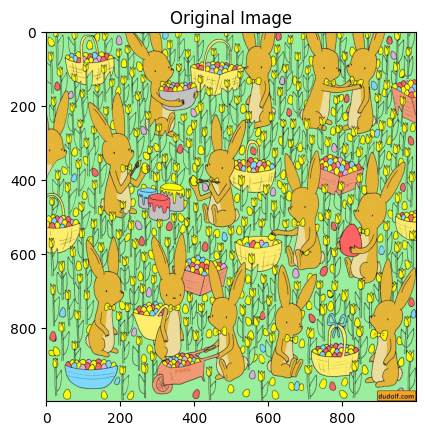

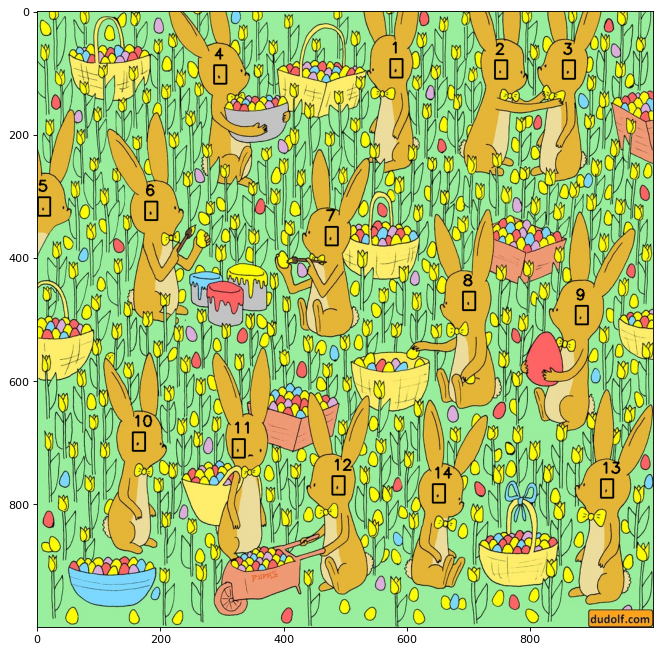

In [9]:
path2 = './rabbit.jpeg'
points = [(155, 685), (175, 715)]

template_matching = TemplateMatching(points, path2)

template_matching.visualize()

template_matching.template_matching_algo(threshold=0.01)
template_matching.filter()

1. Ý tưởng

    Ý tưởng là tìm kiếm và xác định vị trí của một đối tượng cụ thể trong ảnh đầu vào bằng cách sử dụng thuật toán Template Matching. Sau đó, áp dụng phương pháp lọc để loại bỏ các vị trí trùng lặp dựa trên chỉ số IoU (Intersection over Union).

2. Phương pháp tiếp cận
    Bài toán được giải quyết thông qua các bước chính sau:
    
    a) Tiền xử lý dữ liệu
    Đọc ảnh đầu vào sử dụng OpenCV.
    Trích xuất vùng đối tượng cần tìm kiếm từ ảnh dựa trên tọa độ được cung cấp.
    Chuyển đổi ảnh về dạng grayscale để giảm bớt thông tin không cần thiết và tăng hiệu suất tìm kiếm.

    b) Áp dụng Template Matching
    Sử dụng hàm cv2.matchTemplate() của OpenCV để tìm kiếm các vị trí trong ảnh mà template có thể xuất hiện.
    Sử dụng phương pháp cv2.TM_SQDIFF_NORMED để so sánh template với từng vùng trong ảnh.
    Lọc ra các vị trí có độ tương đồng lớn hơn một ngưỡng xác định (threshold).

    c) Lọc các vị trí trùng lặp bằng IoU
    Sau khi xác định các vị trí khả thi, tiến hành kiểm tra mức độ chồng lấn giữa các vị trí bằng cách tính toán chỉ số IoU.
    Chỉ giữ lại những vị trí có IoU thấp để đảm bảo mỗi đối tượng chỉ được nhận diện một lần.

3. Algorithm

    a) Template Matching
    Công thức của phương pháp cv2.TM_SQDIFF_NORMED:
    $$R(x, y) = \sum_{i,j} \left( \frac{T(i,j) - I(x+i, y+j)}{\sqrt{\sum T(i,j)^2 \sum I(x+i, y+j)^2}} \right)$$

    b) Intersection over Union (IoU)
    Công thức tính IoU: 
    $$IoU = \frac{S_{A \cap B}}{S_{A \cup B}}$$
    Dùng để đo mức độ chồng lấn giữa hai hình chữ nhật đại diện cho các kết quả tìm kiếm.
    Nếu IoU > 0.5, coi như hai vùng này là trùng lặp, loại bỏ một trong số đó.